# Facial Recognition Model using Random Forest
## Task 4: Model Creation

This notebook implements a facial recognition system using Random Forest classifier on engineered image features.

In [107]:
# Import necessary libraries
import matplotlib
import pandas as pd
import joblib
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Scikit-learn imports
import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA

# Set style for plots
plt.style.use('default')
sns.set_palette("husl")

print("All libraries imported successfully!")
print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")
print(f"Scikit-learn version: {sklearn.__version__}")
print(f"Matplotlib version: {matplotlib.__version__}")
print(f"Seaborn version: {sns.__version__}")
print(f"Joblib version: {joblib.__version__}")

All libraries imported successfully!
Pandas version: 2.3.3
NumPy version: 1.26.4
Scikit-learn version: 1.3.2
Matplotlib version: 3.10.3
Seaborn version: 0.13.2
Joblib version: 1.3.2


In [108]:
# Set up paths
NOTEBOOK_DIR = Path.cwd()
ROOT_DIR = NOTEBOOK_DIR.parent

# Data paths
IMAGE_FEATURES_PATH = ROOT_DIR / "Image_Processing" / "image_features.csv"

print(f"Notebook Directory: {NOTEBOOK_DIR}")
print(f"Root Directory: {ROOT_DIR}")
print(f"Image Features Path: {IMAGE_FEATURES_PATH}")

Notebook Directory: c:\Users\LENOVO\Desktop\Formative-2__Data-Preprocessing\model_notebook
Root Directory: c:\Users\LENOVO\Desktop\Formative-2__Data-Preprocessing
Image Features Path: c:\Users\LENOVO\Desktop\Formative-2__Data-Preprocessing\Image_Processing\image_features.csv


# 1. Data Loading and Initial Exploration

In this section, we load the engineered image features dataset and perform initial exploration to understand the data structure, distributions, and quality.

In [109]:
# Load the dataset
df = pd.read_csv(IMAGE_FEATURES_PATH)

# Display basic information
print("Dataset Shape:", df.shape)
print("\nFirst 5 rows:")
display(df.head(5))

print("\nDataset Info:")
df.info()

Dataset Shape: (192, 45)

First 5 rows:


,member,expression,augmentation,timestamp,height,width,channels,hist_R_0,hist_R_1,hist_R_2,...,hist_gray_4,hist_gray_5,hist_gray_6,hist_gray_7,mean_intensity,std_intensity,min_intensity,max_intensity,median_intensity,edge_density
0,Erneste,Neutral,Original,2025-11-13 16:14:36,3392,2544,3,0.007433,0.041294,0.053771,...,0.039744,0.209152,0.570814,0.000025,172.553377,48.366806,0,255,195.0,0.001253
1,Erneste,Neutral,Rotation_15deg,2025-11-13 16:14:36,3392,2544,3,0.113545,0.041573,0.052442,...,0.038196,0.151264,0.526574,0.000023,152.626386,71.055705,0,253,194.0,0.001589
2,Erneste,Neutral,Horizontal_Flip,2025-11-13 16:14:37,3392,2544,3,0.007433,0.041294,0.053771,...,0.039744,0.209152,0.570814,0.000025,172.553377,48.366806,0,255,195.0,0.001247
3,Erneste,Neutral,Grayscale,2025-11-13 16:14:37,3392,2544,3,0.010438,0.055224,0.055401,...,0.039744,0.209152,0.570814,0.000025,172.553377,48.366806,0,255,195.0,0.001253
4,Erneste,Neutral,Brightness_+30,2025-11-13 16:14:37,3392,2544,3,0.000100,0.008599,0.043795,...,0.061621,0.035216,0.236210,0.542734,202.553116,48.366494,30,255,225.0,0.001251



Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 192 entries, 0 to 191
Data columns (total 45 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   member            192 non-null    object 
 1   expression        192 non-null    object 
 2   augmentation      192 non-null    object 
 3   timestamp         192 non-null    object 
 4   height            192 non-null    int64  
 5   width             192 non-null    int64  
 6   channels          192 non-null    int64  
 7   hist_R_0          192 non-null    float64
 8   hist_R_1          192 non-null    float64
 9   hist_R_2          192 non-null    float64
 10  hist_R_3          192 non-null    float64
 11  hist_R_4          192 non-null    float64
 12  hist_R_5          192 non-null    float64
 13  hist_R_6          192 non-null    float64
 14  hist_R_7          192 non-null    float64
 15  hist_G_0          192 non-null    float64
 16  hist_G_1          192 non-nul

In [110]:
# Summary statistics
print("Summary Statistics:")
display(df.describe())

# Check for missing values
print("\nMissing Values Analysis:")
missing_data = df.isnull().sum()
missing_percentage = (missing_data / len(df)) * 100
missing_info = pd.DataFrame({'Missing Count': missing_data, 'Percentage': missing_percentage})
display(missing_info[missing_info['Missing Count'] > 0])

# Check target variable distribution
if 'person_id' in df.columns:
    target_col = 'person_id'
elif 'label' in df.columns:
    target_col = 'label'
else:
    # Use the first column that seems to be a target
    target_col = df.columns[0]
    
print(f"\nTarget variable: {target_col}")
print(f"Number of unique classes: {df[target_col].nunique()}")
print(f"Class distribution:\n{df[target_col].value_counts()}")

Summary Statistics:


,height,width,channels,hist_R_0,hist_R_1,hist_R_2,hist_R_3,hist_R_4,hist_R_5,hist_R_6,...,hist_gray_4,hist_gray_5,hist_gray_6,hist_gray_7,mean_intensity,std_intensity,min_intensity,max_intensity,median_intensity,edge_density
count,192.000000,192.000000,192.0,192.000000,192.000000,192.000000,192.000000,192.000000,192.000000,192.000000,...,192.000000,192.000000,192.000000,192.000000,192.000000,192.000000,192.000000,192.000000,192.000000,192.000000
mean,1951.333333,1273.500000,3.0,0.111588,0.057696,0.080823,0.119541,0.143329,0.193341,0.207585,...,0.126151,0.172157,0.199845,0.085621,137.749825,61.030497,3.640625,241.859375,146.690104,0.014605
std,879.893885,749.253367,0.0,0.136445,0.047445,0.047670,0.082032,0.106110,0.137455,0.197457,...,0.111779,0.143087,0.199466,0.162413,33.687028,16.379333,8.086639,21.658850,45.008249,0.013679
min,1080.000000,720.000000,3.0,0.000000,0.003888,0.019492,0.029952,0.025805,0.000000,0.000000,...,0.021954,0.000000,0.000000,0.000000,61.021442,30.575943,0.000000,153.000000,60.000000,0.000228
25%,1280.000000,720.000000,3.0,0.006553,0.031349,0.053082,0.060273,0.066162,0.105254,0.059630,...,0.051114,0.070097,0.044822,0.000026,109.789884,48.366806,0.000000,235.000000,110.750000,0.004293
50%,1600.000000,945.000000,3.0,0.032364,0.044758,0.070312,0.095241,0.122728,0.179420,0.114533,...,0.070289,0.131731,0.142717,0.002303,140.695836,56.230423,0.000000,254.000000,146.500000,0.009856
75%,2288.000000,1446.000000,3.0,0.175969,0.065362,0.092752,0.139917,0.202606,0.226249,0.266351,...,0.212300,0.244465,0.217122,0.073197,158.277539,76.543180,2.000000,255.000000,188.750000,0.022512
max,3392.000000,2544.000000,3.0,0.443007,0.228614,0.408045,0.511477,0.697123,0.722014,0.726989,...,0.701677,0.730655,0.748617,0.792253,227.896085,105.698933,32.000000,255.000000,255.000000,0.075149



Missing Values Analysis:


,Missing Count,Percentage



Target variable: member
Number of unique classes: 4
Class distribution:
member
Erneste    48
Thierry    48
Rodas      48
Idara      48
Name: count, dtype: int64


# 2. Exploratory Data Analysis (EDA)

Comprehensive EDA to understand feature distributions, correlations, and data patterns that might impact model performance.

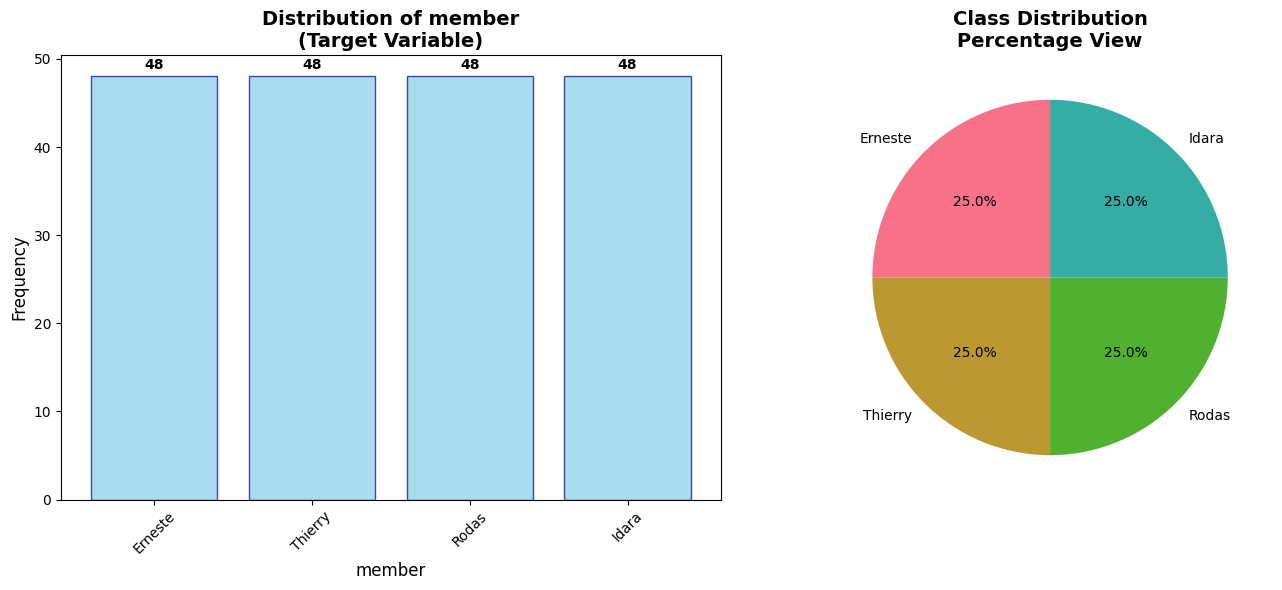

Class balance analysis:
Majority class: Erneste with 48 samples
Minority class: Erneste with 48 samples
Imbalance ratio: 1.00


In [111]:
# Plot 1: Distribution of Target Variable with enhanced visualization
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
class_counts = df[target_col].value_counts()
bars = plt.bar(range(len(class_counts)), class_counts.values, color='skyblue', edgecolor='navy', alpha=0.7)
plt.title(f'Distribution of {target_col}\n(Target Variable)', fontsize=14, fontweight='bold')
plt.xlabel(target_col, fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xticks(range(len(class_counts)), class_counts.index, rotation=45)

# Add value labels on bars
for bar, count in zip(bars, class_counts.values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
             str(count), ha='center', va='bottom', fontweight='bold')

plt.subplot(1, 2, 2)
plt.pie(class_counts.values, labels=class_counts.index, autopct='%1.1f%%', startangle=90)
plt.title(f'Class Distribution\nPercentage View', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"Class balance analysis:")
print(f"Majority class: {class_counts.idxmax()} with {class_counts.max()} samples")
print(f"Minority class: {class_counts.idxmin()} with {class_counts.min()} samples")
print(f"Imbalance ratio: {class_counts.max()/class_counts.min():.2f}")

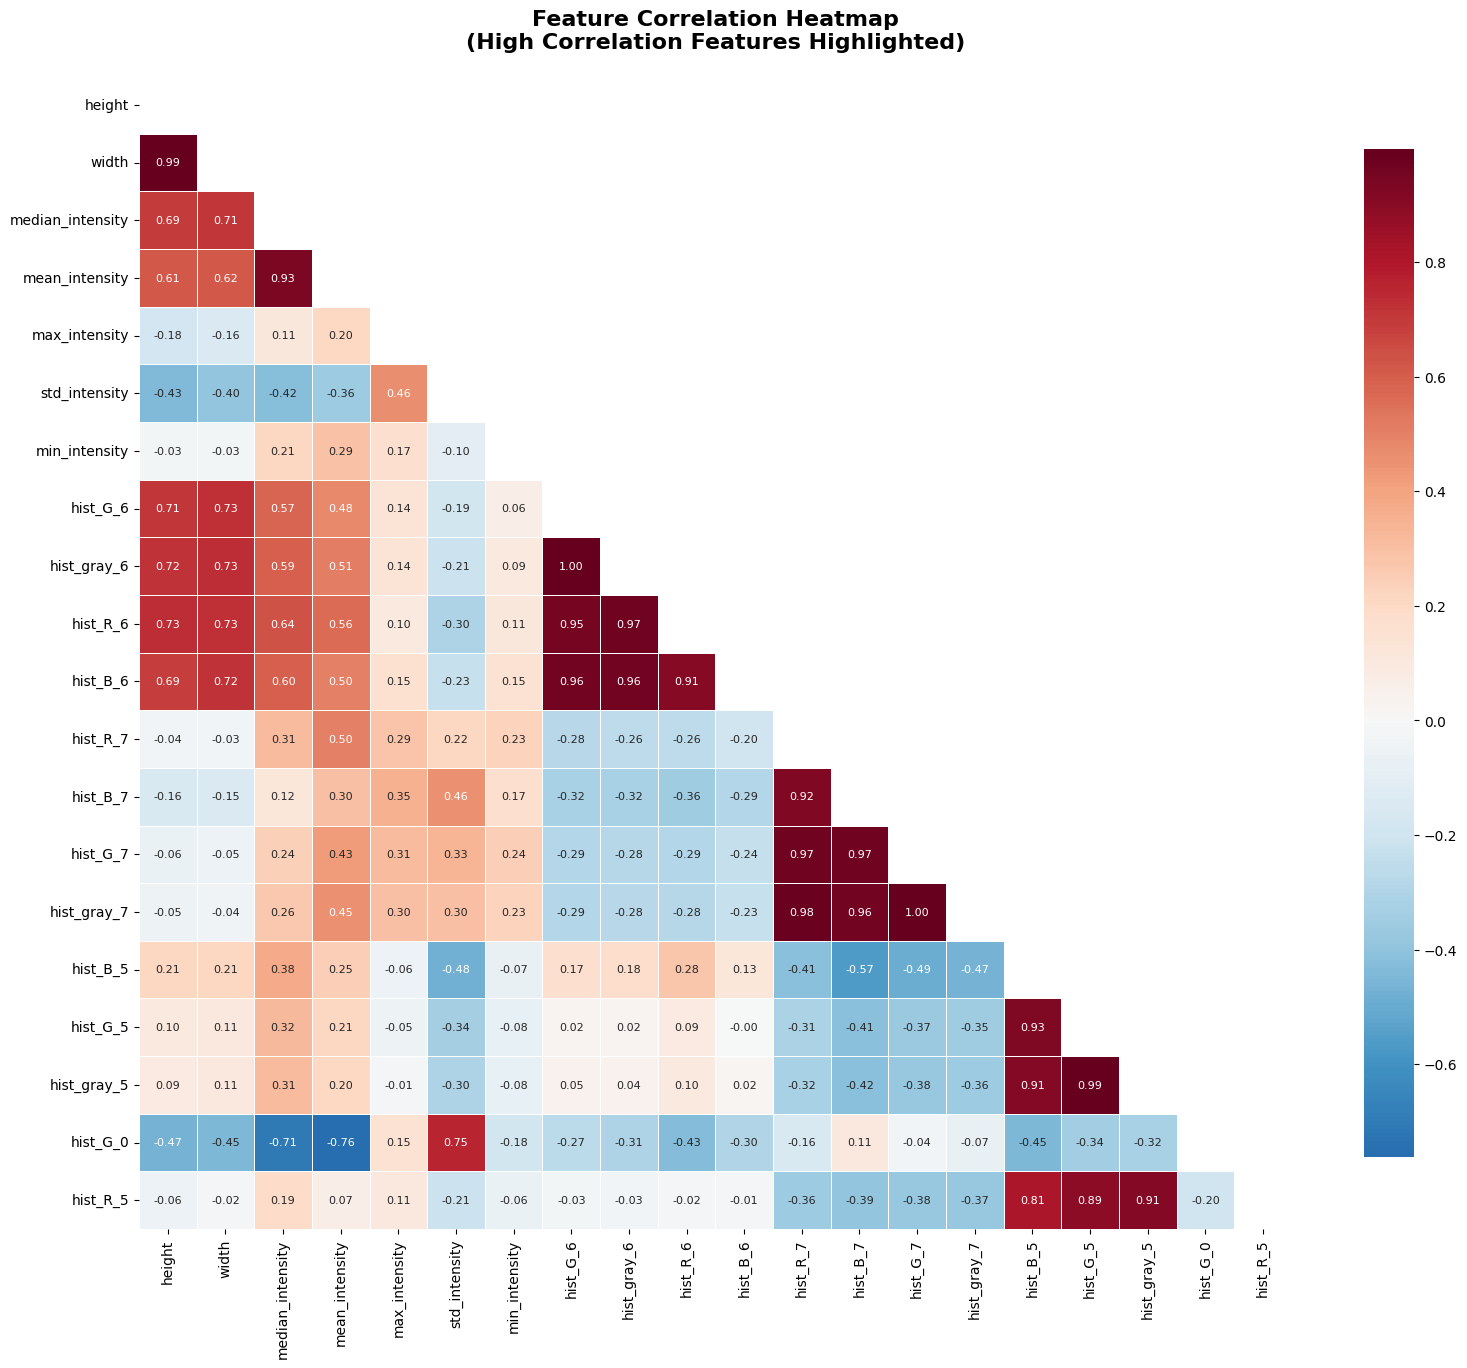


Highly correlated feature pairs (correlation > 0.8):
hist_G_7 - hist_gray_7: 0.998
hist_gray_7 - hist_G_7: 0.998
hist_G_6 - hist_gray_6: 0.997
hist_gray_6 - hist_G_6: 0.997
hist_gray_5 - hist_G_5: 0.994
hist_G_5 - hist_gray_5: 0.994
width - height: 0.987
height - width: 0.987
hist_R_7 - hist_gray_7: 0.981
hist_gray_7 - hist_R_7: 0.981
hist_R_7 - hist_G_7: 0.970
hist_G_7 - hist_R_7: 0.970
hist_G_7 - hist_B_7: 0.968
hist_B_7 - hist_G_7: 0.968
hist_R_6 - hist_gray_6: 0.967
hist_gray_6 - hist_R_6: 0.967
hist_B_6 - hist_G_6: 0.962
hist_G_6 - hist_B_6: 0.962
hist_gray_7 - hist_B_7: 0.959
hist_B_7 - hist_gray_7: 0.959
hist_gray_6 - hist_B_6: 0.959
hist_B_6 - hist_gray_6: 0.959
hist_G_6 - hist_R_6: 0.953
hist_R_6 - hist_G_6: 0.953
median_intensity - mean_intensity: 0.934
mean_intensity - median_intensity: 0.934
hist_G_5 - hist_B_5: 0.928
hist_B_5 - hist_G_5: 0.928
hist_B_7 - hist_R_7: 0.920
hist_R_7 - hist_B_7: 0.920
hist_B_5 - hist_gray_5: 0.914
hist_gray_5 - hist_B_5: 0.914
hist_R_5 - hist_

In [112]:
# Plot 2: Feature Correlations Heatmap with enhanced analysis
numerical_cols = df.select_dtypes(include=[np.number]).columns
if target_col in numerical_cols:
    numerical_cols = numerical_cols.drop(target_col)

# Take top 20 numerical features for better visualization
if len(numerical_cols) > 20:
    # Select features with highest variance
    variances = df[numerical_cols].var().sort_values(ascending=False)
    numerical_cols = variances.head(20).index

plt.figure(figsize=(16, 14))
correlation_matrix = df[numerical_cols].corr()
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='RdBu_r', center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": .8}, fmt='.2f',
            annot_kws={'size': 8})
plt.title('Feature Correlation Heatmap\n(High Correlation Features Highlighted)', 
          fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

# Identify highly correlated features
corr_pairs = correlation_matrix.unstack().sort_values(ascending=False)
high_corr = corr_pairs[(corr_pairs < 1.0) & (corr_pairs > 0.8)]
if len(high_corr) > 0:
    print("\nHighly correlated feature pairs (correlation > 0.8):")
    for pair, corr_val in high_corr.items():
        print(f"{pair[0]} - {pair[1]}: {corr_val:.3f}")

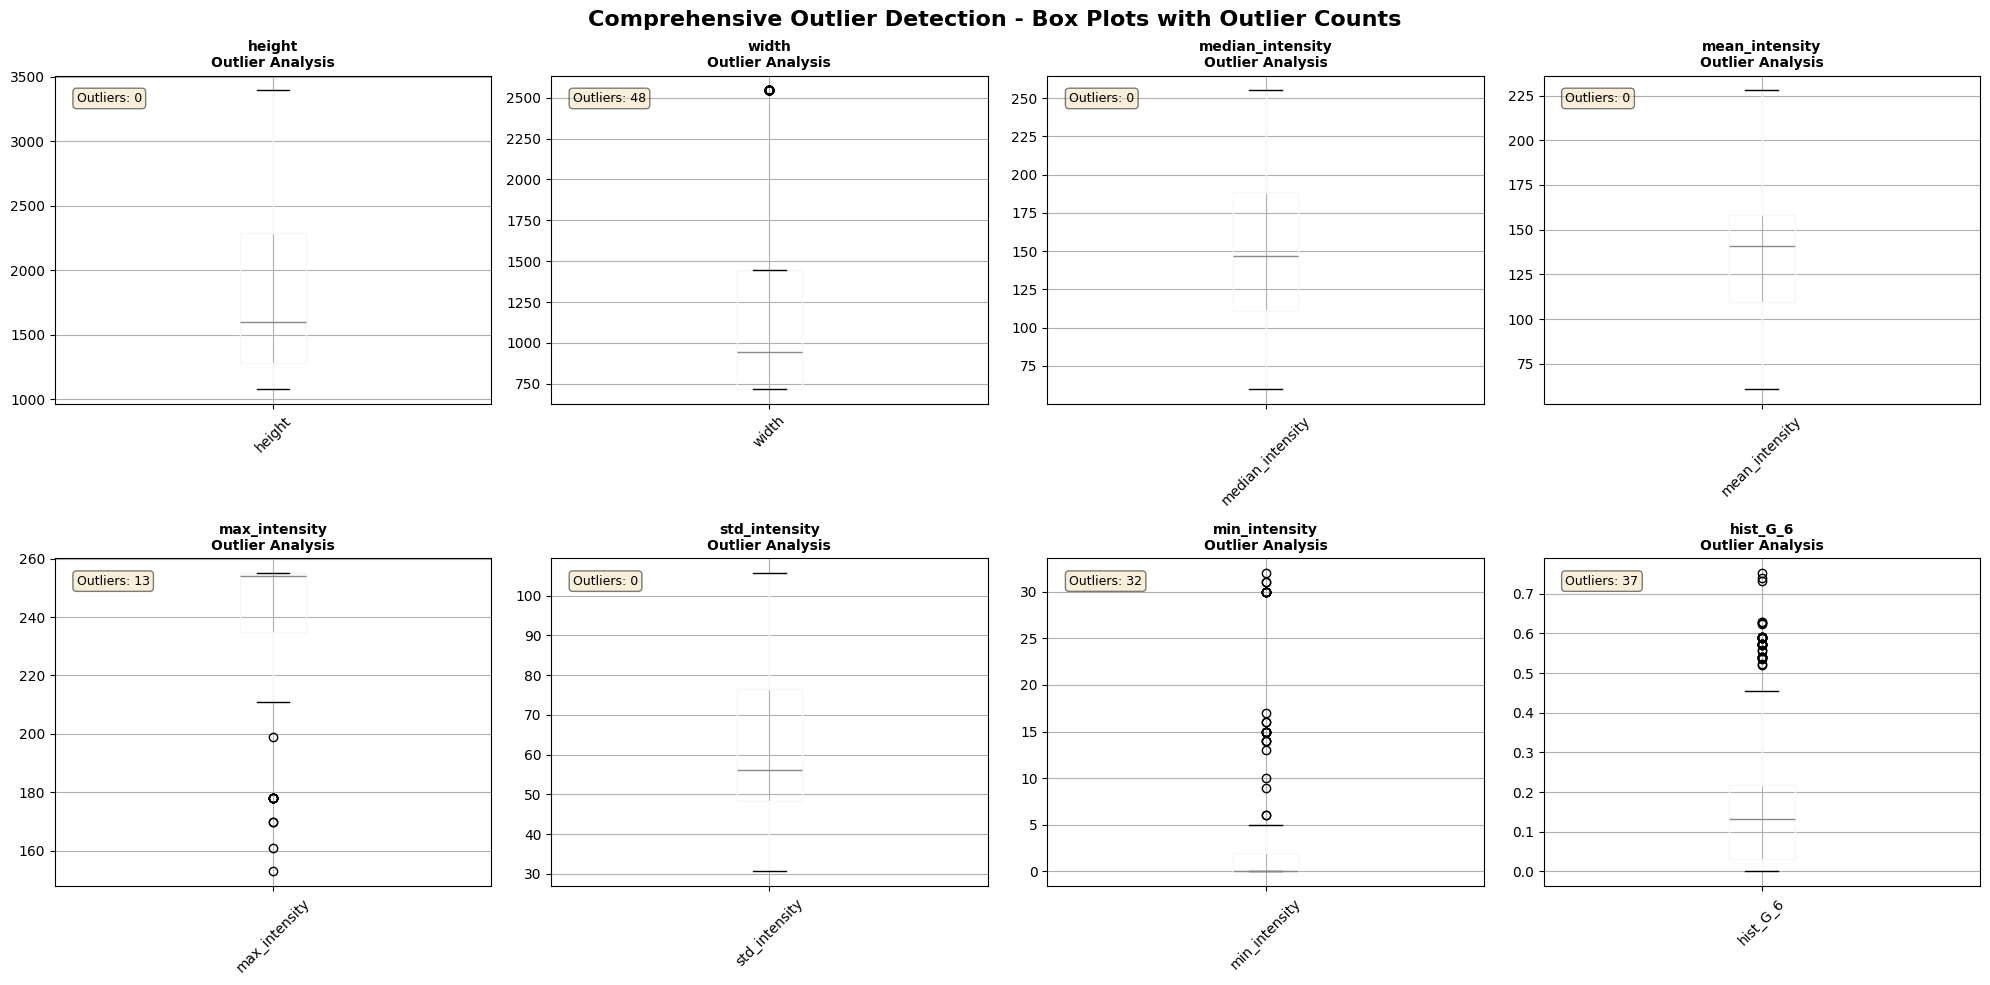

In [113]:
# Plot 3: Outlier Detection using Box Plots and Distribution Analysis
if len(numerical_cols) > 8:
    plot_features = numerical_cols[:8]
else:
    plot_features = numerical_cols

fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.ravel()

for i, col in enumerate(plot_features):
    # Boxplot
    df.boxplot(column=col, ax=axes[i])
    axes[i].set_title(f'{col}\nOutlier Analysis', fontweight='bold', fontsize=10)
    axes[i].tick_params(axis='x', rotation=45)
    
    # Add outlier count annotation
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    outlier_count = ((df[col] < (Q1 - 1.5 * IQR)) | (df[col] > (Q3 + 1.5 * IQR))).sum()
    axes[i].text(0.05, 0.95, f'Outliers: {outlier_count}', transform=axes[i].transAxes, 
                fontsize=9, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Hide empty subplots
for i in range(len(plot_features), len(axes)):
    axes[i].set_visible(False)

plt.suptitle('Comprehensive Outlier Detection - Box Plots with Outlier Counts', 
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

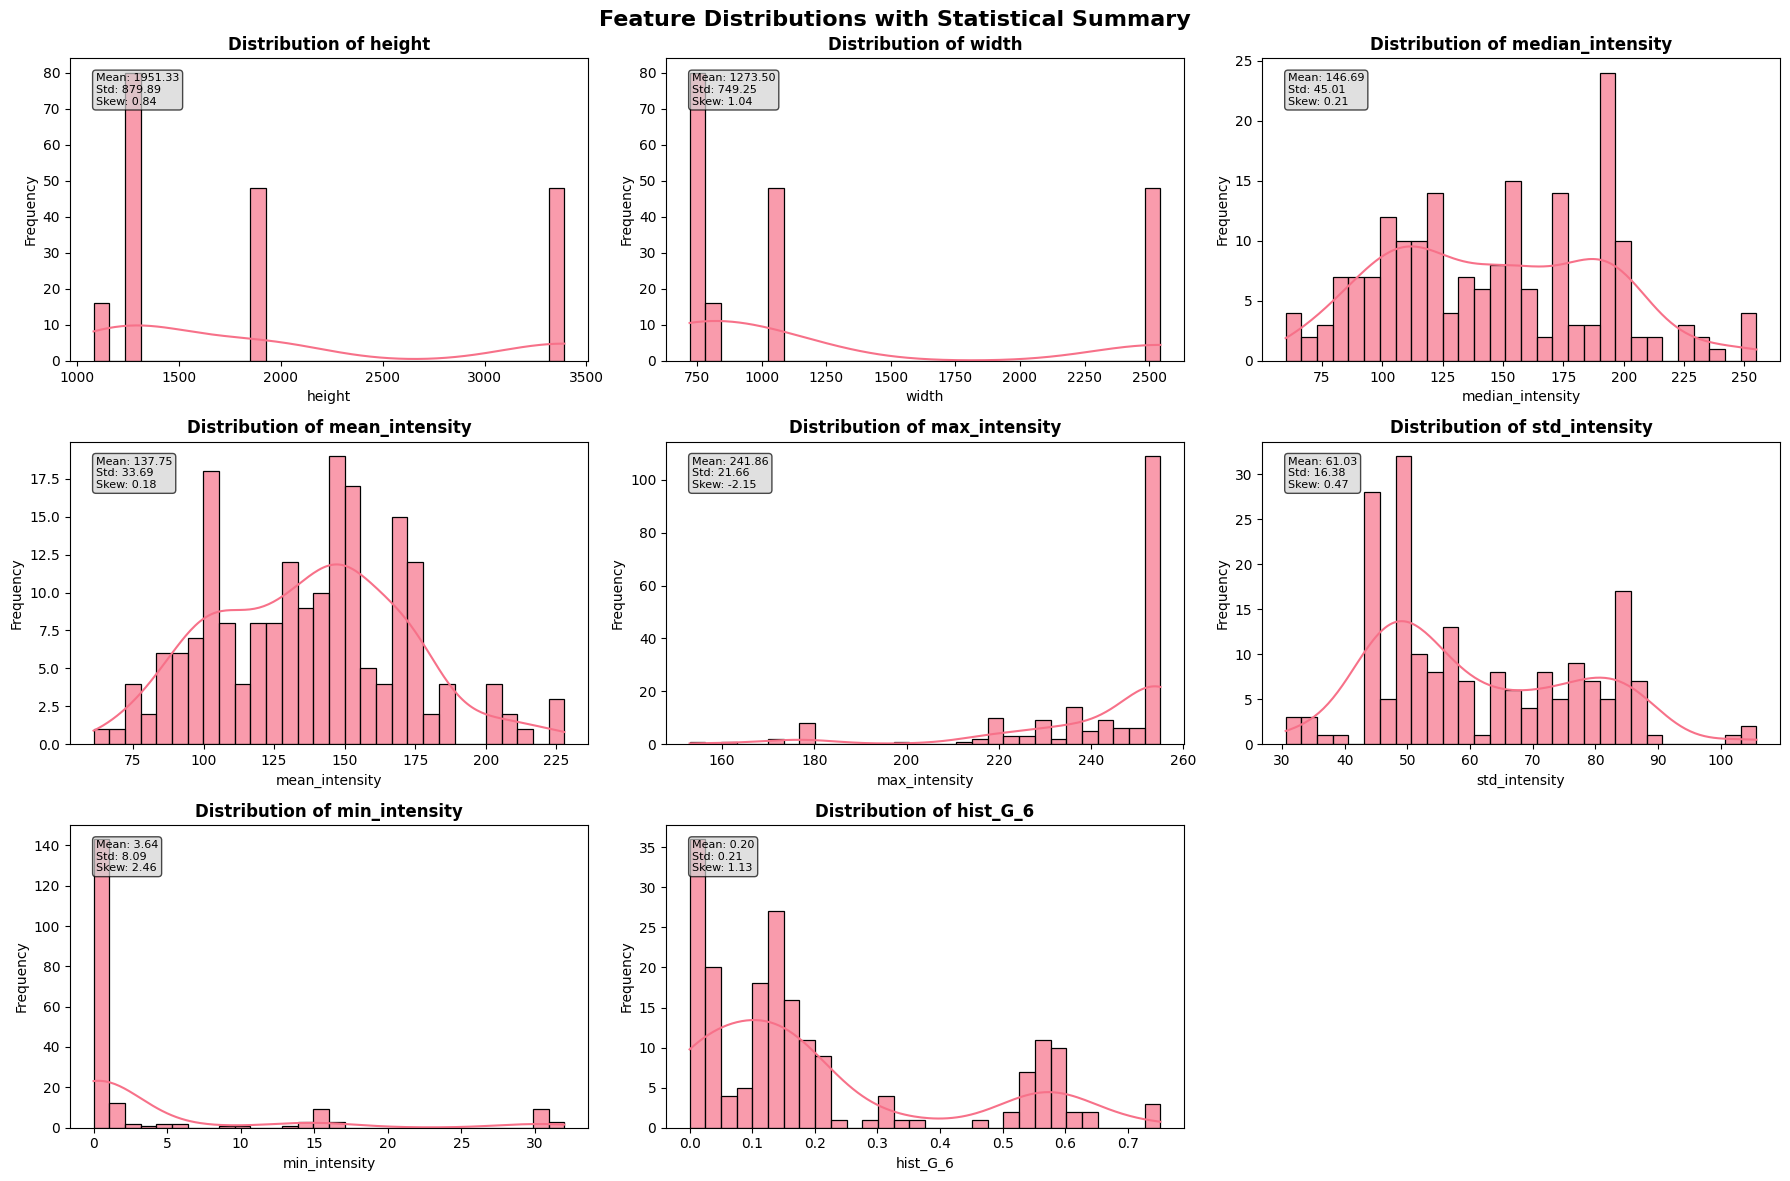

In [114]:
# Additional Plot: Feature Distributions with Statistical Summary
plt.figure(figsize=(18, 12))
for i, col in enumerate(plot_features):
    plt.subplot(3, 3, i+1)
    
    # Histogram with KDE
    sns.histplot(df[col], kde=True, bins=30, alpha=0.7, edgecolor='black')
    plt.title(f'Distribution of {col}', fontweight='bold')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    
    # Add statistical information
    stats_text = f'Mean: {df[col].mean():.2f}\nStd: {df[col].std():.2f}\nSkew: {df[col].skew():.2f}'
    plt.text(0.05, 0.95, stats_text, transform=plt.gca().transAxes, 
             fontsize=8, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.7))

plt.suptitle('Feature Distributions with Statistical Summary', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

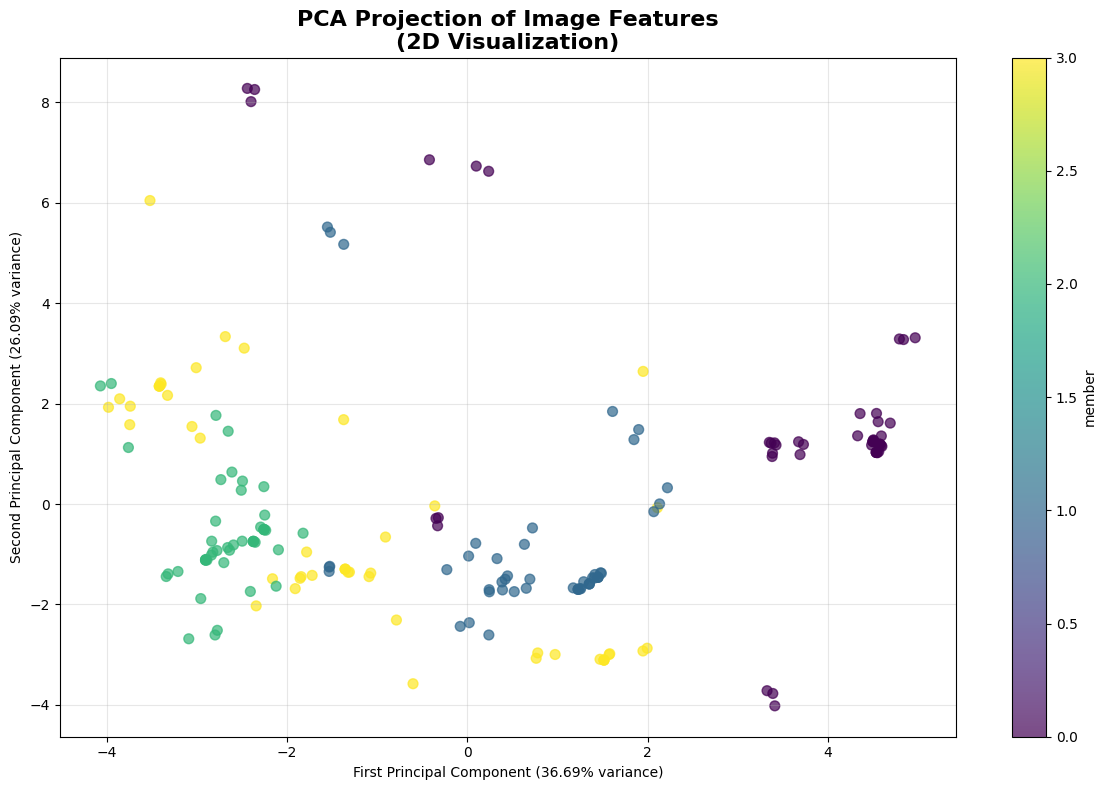

PCA Explained Variance: 62.78%
Individual components: PC1=36.69%, PC2=26.09%


In [115]:
# New Visualization: PCA Projection for Dimensionality Insight
if len(numerical_cols) > 2:
    # Prepare data for PCA
    X_temp = df[numerical_cols].fillna(df[numerical_cols].mean())
    scaler_temp = StandardScaler()
    X_scaled_temp = scaler_temp.fit_transform(X_temp)
    
    # Apply PCA
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled_temp)
    
    plt.figure(figsize=(12, 8))
    scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], 
                         c=df[target_col].astype('category').cat.codes if df[target_col].dtype == 'object' else df[target_col],
                         cmap='viridis', alpha=0.7, s=50)
    plt.colorbar(scatter, label=target_col)
    plt.xlabel(f'First Principal Component ({pca.explained_variance_ratio_[0]:.2%} variance)')
    plt.ylabel(f'Second Principal Component ({pca.explained_variance_ratio_[1]:.2%} variance)')
    plt.title('PCA Projection of Image Features\n(2D Visualization)', fontsize=16, fontweight='bold')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    print(f"PCA Explained Variance: {pca.explained_variance_ratio_.sum():.2%}")
    print(f"Individual components: PC1={pca.explained_variance_ratio_[0]:.2%}, PC2={pca.explained_variance_ratio_[1]:.2%}")

# 3. Data Preprocessing

Prepare the data for modeling by handling categorical variables, encoding labels, and scaling features.

In [116]:
# Prepare features and target
X = df.drop(columns=[target_col])
y = df[target_col]

# Handle categorical features if any
categorical_cols = X.select_dtypes(include=['object']).columns
if len(categorical_cols) > 0:
    print(f"Categorical features found: {list(categorical_cols)}")
    X = pd.get_dummies(X, columns=categorical_cols, drop_first=True)
    print(f"After one-hot encoding: {X.shape[1]} features")

# Encode target variable if it's categorical
if y.dtype == 'object':
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)
    print(f"Target classes encoded: {le.classes_}")
    print(f"Class mapping: {dict(zip(le.classes_, le.transform(le.classes_)))}")
else:
    y_encoded = y.values
    print("Target variable is numerical, no encoding needed")

# Handle missing values in features
missing_before = X.isnull().sum().sum()
X = X.fillna(X.mean())  # Fill numerical missing values with mean
missing_after = X.isnull().sum().sum()
print(f"Missing values handled: {missing_before} -> {missing_after}")

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f"\nFinal dataset shape:")
print(f"Feature matrix: {X_scaled.shape}")
print(f"Target vector: {y_encoded.shape}")
print(f"Number of classes: {len(np.unique(y_encoded))}")

Categorical features found: ['expression', 'augmentation', 'timestamp']
After one-hot encoding: 73 features
Target classes encoded: ['Erneste' 'Idara' 'Rodas' 'Thierry']
Class mapping: {'Erneste': 0, 'Idara': 1, 'Rodas': 2, 'Thierry': 3}
Missing values handled: 0 -> 0

Final dataset shape:
Feature matrix: (192, 73)
Target vector: (192,)
Number of classes: 4


# 4. Model Training - Random Forest

Implement Random Forest classifier with appropriate hyperparameters for facial recognition task.

In [117]:
# Split the data with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

print("=== Data Split Summary ===")
print(f"Training set size: {X_train.shape[0]} samples ({X_train.shape[0]/len(X_scaled)*100:.1f}%)")
print(f"Test set size: {X_test.shape[0]} samples ({X_test.shape[0]/len(X_scaled)*100:.1f}%)")
print(f"Number of features: {X_train.shape[1]}")
print(f"Training set class distribution: {np.bincount(y_train)}")
print(f"Test set class distribution: {np.bincount(y_test)}")

=== Data Split Summary ===
Training set size: 153 samples (79.7%)
Test set size: 39 samples (20.3%)
Number of features: 73
Training set class distribution: [38 39 38 38]
Test set class distribution: [10  9 10 10]


In [118]:
# Initialize and train Random Forest model with enhanced parameters
rf_model = RandomForestClassifier(
    n_estimators=150,  # Increased for better performance
    max_depth=15,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features='sqrt',  # Better for high-dimensional data
    bootstrap=True,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

print("Training Random Forest model...")
rf_model.fit(X_train, y_train)

# Make predictions
y_pred = rf_model.predict(X_test)
y_pred_proba = rf_model.predict_proba(X_test)

print("\nRandom Forest Model Training Completed!")
print(f"Number of trees: {len(rf_model.estimators_)}")
print(f"Feature importance shape: {rf_model.feature_importances_.shape}")

Training Random Forest model...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s



Random Forest Model Training Completed!
Number of trees: 150
Feature importance shape: (73,)


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 150 out of 150 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 150 out of 150 | elapsed:    0.0s finished


# 5. Model Evaluation

Comprehensive evaluation using multiple metrics and visualization techniques.

In [119]:
# Calculate comprehensive metrics
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')

# Calculate log loss manually
epsilon = 1e-15
y_pred_proba = np.clip(y_pred_proba, epsilon, 1 - epsilon)
log_loss = -np.mean(np.log(y_pred_proba[np.arange(len(y_test)), y_test]))

# Cross-validation scores
cv_scores = cross_val_score(rf_model, X_scaled, y_encoded, cv=5, scoring='accuracy')

print("=== COMPREHENSIVE MODEL EVALUATION ===")
print(f"\nPrimary Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"F1-Score (weighted): {f1:.4f}")
print(f"Log Loss: {log_loss:.4f}")

print(f"\nCross-Validation Performance:")
print(f"Mean CV Accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
print(f"Individual CV scores: {cv_scores}")

# Performance interpretation
print(f"\nPerformance Interpretation:")
if accuracy > 0.9:
    print(" Excellent performance for facial recognition")
elif accuracy > 0.8:
    print(" Good performance")
elif accuracy > 0.7:
    print(" Moderate performance - consider feature engineering")
else:
    print(" Needs improvement - review features and model parameters")

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 150 out of 150 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 150 out of 150 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parall

=== COMPREHENSIVE MODEL EVALUATION ===

Primary Metrics:
Accuracy: 1.0000
F1-Score (weighted): 1.0000
Log Loss: 0.0774

Cross-Validation Performance:
Mean CV Accuracy: 1.0000 (+/- 0.0000)
Individual CV scores: [1. 1. 1. 1. 1.]

Performance Interpretation:
 Excellent performance for facial recognition


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 150 out of 150 | elapsed:    0.0s finished


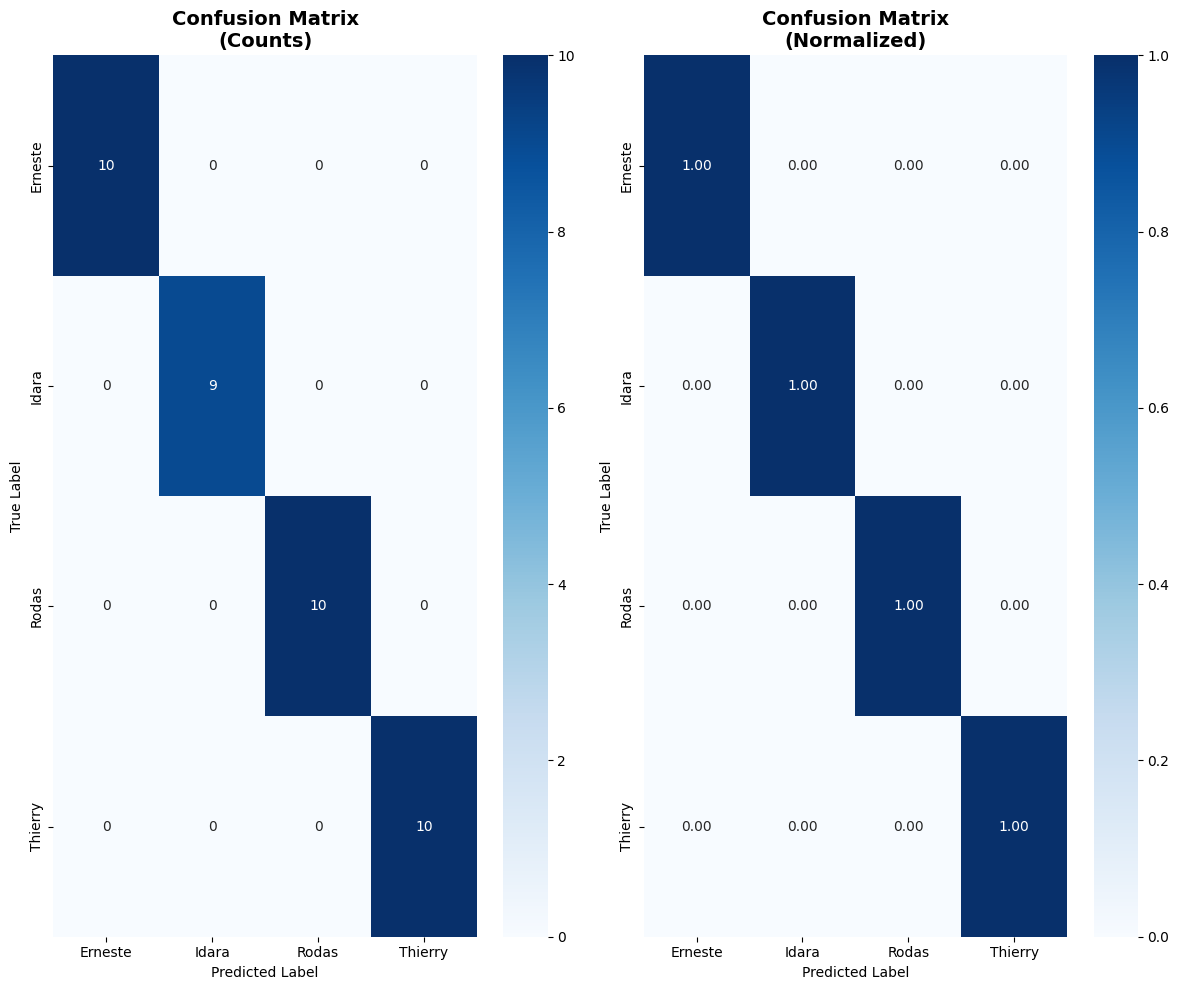


Per-class Accuracy:
Class Erneste: 1.000
Class Idara: 1.000
Class Rodas: 1.000
Class Thierry: 1.000


In [120]:
# Enhanced Confusion Matrix with normalized values
plt.figure(figsize=(12, 10))

cm = confusion_matrix(y_test, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.subplot(1, 2, 1)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=le.classes_ if 'le' in locals() else np.unique(y_encoded),
            yticklabels=le.classes_ if 'le' in locals() else np.unique(y_encoded))
plt.title('Confusion Matrix\n(Counts)', fontsize=14, fontweight='bold')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

plt.subplot(1, 2, 2)
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', 
            xticklabels=le.classes_ if 'le' in locals() else np.unique(y_encoded),
            yticklabels=le.classes_ if 'le' in locals() else np.unique(y_encoded))
plt.title('Confusion Matrix\n(Normalized)', fontsize=14, fontweight='bold')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

plt.tight_layout()
plt.show()

# Calculate per-class accuracy
class_accuracy = cm.diagonal() / cm.sum(axis=1)
print("\nPer-class Accuracy:")
for i, acc in enumerate(class_accuracy):
    class_name = le.classes_[i] if 'le' in locals() else i
    print(f"Class {class_name}: {acc:.3f}")

In [121]:
# Detailed classification report with support
print("\n=== DETAILED CLASSIFICATION REPORT ===")
if 'le' in locals():
    print(classification_report(y_test, y_pred, target_names=le.classes_, digits=3))
else:
    print(classification_report(y_test, y_pred, digits=3))


=== DETAILED CLASSIFICATION REPORT ===
              precision    recall  f1-score   support

     Erneste      1.000     1.000     1.000        10
       Idara      1.000     1.000     1.000         9
       Rodas      1.000     1.000     1.000        10
     Thierry      1.000     1.000     1.000        10

    accuracy                          1.000        39
   macro avg      1.000     1.000     1.000        39
weighted avg      1.000     1.000     1.000        39



# 6. Feature Importance Analysis

Understand which features contribute most to the model's predictions.

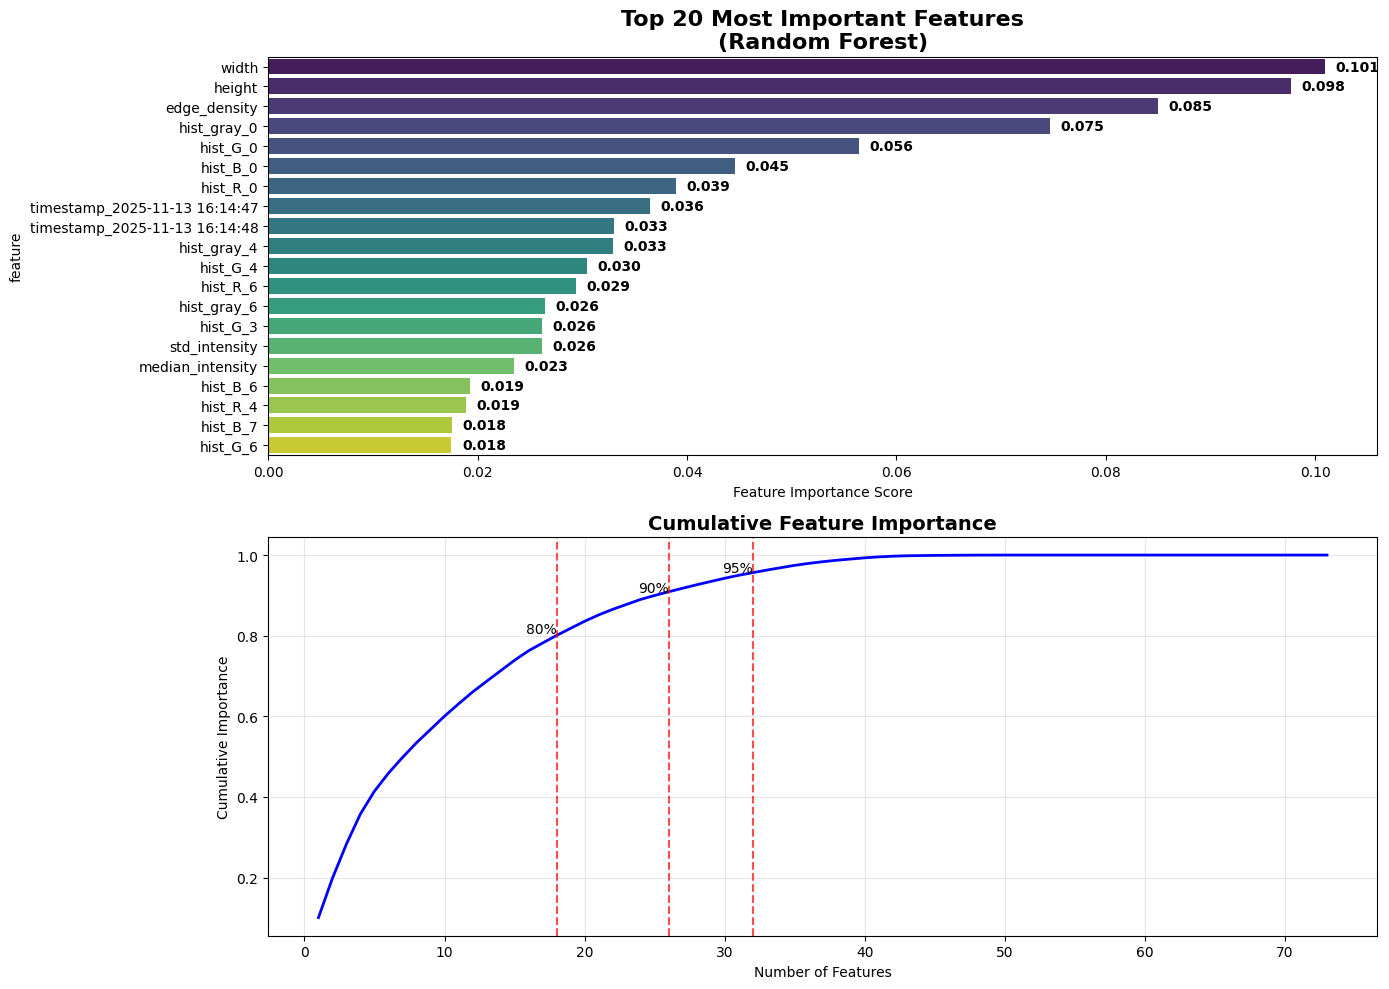


Top 10 Most Important Features:


,feature,importance
1,width,0.100872
0,height,0.097703
40,edge_density,0.084970
27,hist_gray_0,0.074610
11,hist_G_0,0.056393
19,hist_B_0,0.044587
3,hist_R_0,0.038913
68,timestamp_2025-11-13 16:14:47,0.036433
69,timestamp_2025-11-13 16:14:48,0.032998
31,hist_gray_4,0.032970



Feature Importance Statistics:
Max importance: 0.1009
Min importance: 0.0000
Mean importance: 0.0137
Features with importance > 0.01: 24


In [122]:
# Get feature importances
feature_importances = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

# Plot top 20 most important features
plt.figure(figsize=(14, 10))
top_features = feature_importances.head(20)

plt.subplot(2, 1, 1)
bars = sns.barplot(data=top_features, x='importance', y='feature', palette='viridis')
plt.title('Top 20 Most Important Features\n(Random Forest)', fontsize=16, fontweight='bold')
plt.xlabel('Feature Importance Score')

# Add value labels
for i, patch in enumerate(bars.patches):
    bars.annotate(f'{patch.get_width():.3f}', 
                  (patch.get_width() + 0.001, patch.get_y() + patch.get_height()/2),
                  ha='left', va='center', fontweight='bold')

plt.subplot(2, 1, 2)
cumulative_importance = feature_importances['importance'].cumsum()
plt.plot(range(1, len(cumulative_importance) + 1), cumulative_importance, 'b-', linewidth=2)
plt.xlabel('Number of Features')
plt.ylabel('Cumulative Importance')
plt.title('Cumulative Feature Importance', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)

# Add important thresholds
for threshold in [0.8, 0.9, 0.95]:
    idx = np.argmax(cumulative_importance >= threshold)
    plt.axvline(x=idx+1, color='red', linestyle='--', alpha=0.7)
    plt.text(idx+1, threshold, f'{threshold*100:.0f}%', ha='right', va='bottom')

plt.tight_layout()
plt.show()

print("\nTop 10 Most Important Features:")
display(top_features.head(10))

# Feature importance statistics
print(f"\nFeature Importance Statistics:")
print(f"Max importance: {feature_importances['importance'].max():.4f}")
print(f"Min importance: {feature_importances['importance'].min():.4f}")
print(f"Mean importance: {feature_importances['importance'].mean():.4f}")
print(f"Features with importance > 0.01: {(feature_importances['importance'] > 0.01).sum()}")

# 7. Model Performance Visualization

Comprehensive visualization of model performance and learning characteristics.

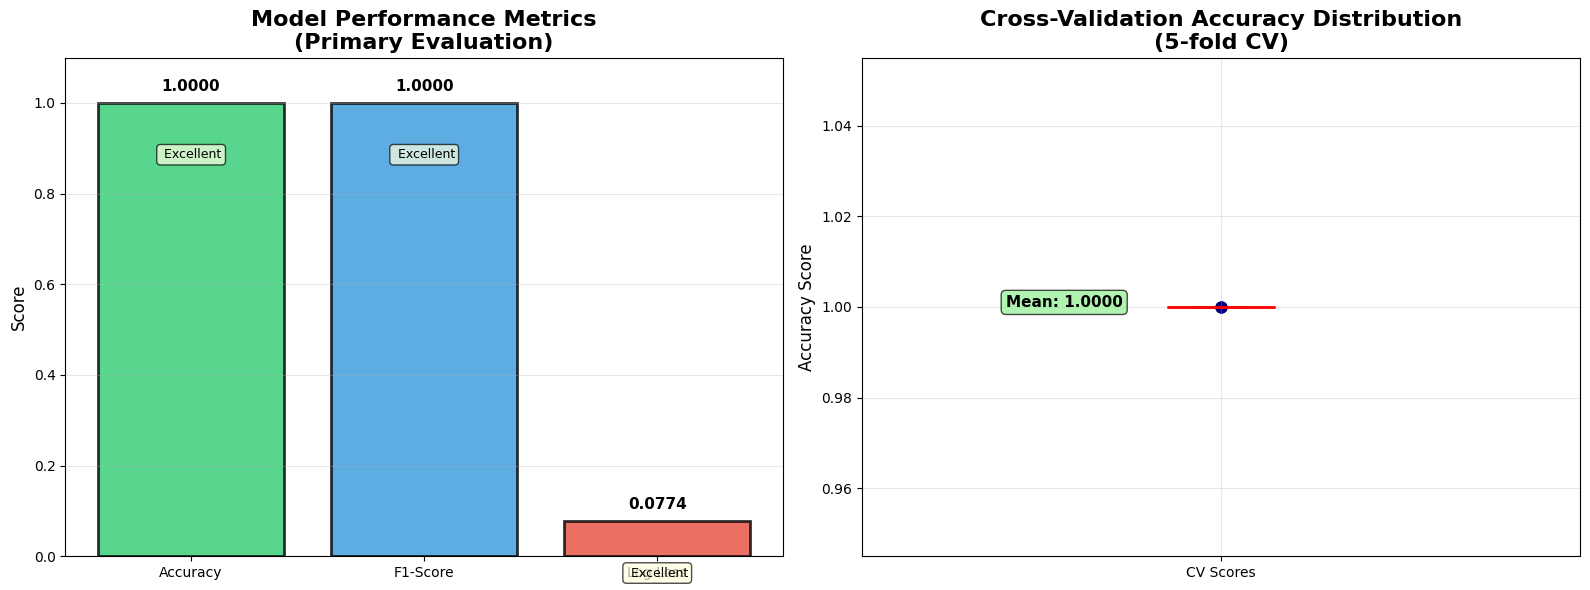

In [123]:
# Enhanced Performance Metrics Visualization
metrics = ['Accuracy', 'F1-Score', 'Log Loss']
values = [accuracy, f1, log_loss]
colors = ['#2ecc71', '#3498db', '#e74c3c']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Bar chart
bars = ax1.bar(metrics, values, color=colors, alpha=0.8, edgecolor='black', linewidth=2)
ax1.set_title('Model Performance Metrics\n(Primary Evaluation)', fontsize=16, fontweight='bold')
ax1.set_ylabel('Score', fontsize=12)
ax1.set_ylim(0, 1.1)
ax1.grid(axis='y', alpha=0.3)

# Add value labels and performance indicators
for bar, value, metric in zip(bars, values, metrics):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2, height + 0.02, 
             f'{value:.4f}', ha='center', va='bottom', fontweight='bold', fontsize=11)
    
    # Add performance indicator
    if metric != 'Log Loss':
        if value > 0.9:
            indicator = ' Excellent'
        elif value > 0.8:
            indicator = ' Good'
        elif value > 0.7:
            indicator = ' Moderate'
        else:
            indicator = ' Needs Improvement'
    else:
        if value < 0.3:
            indicator = ' Excellent'
        elif value < 0.5:
            indicator = ' Good'
        elif value < 0.7:
            indicator = ' Moderate'
        else:
            indicator = ' Needs Improvement'
            
    ax1.text(bar.get_x() + bar.get_width()/2, height - 0.1, 
             indicator, ha='center', va='top', fontsize=9, 
             bbox=dict(boxstyle='round,pad=0.3', facecolor='lightyellow', alpha=0.7))

# Cross-validation scores
ax2.boxplot(cv_scores, vert=True, patch_artist=True, 
           boxprops=dict(facecolor='lightblue', color='navy'),
           medianprops=dict(color='red', linewidth=2))
ax2.scatter(np.ones_like(cv_scores), cv_scores, alpha=0.6, color='navy', s=60)
ax2.set_title('Cross-Validation Accuracy Distribution\n(5-fold CV)', fontsize=16, fontweight='bold')
ax2.set_ylabel('Accuracy Score', fontsize=12)
ax2.set_xticks([1])
ax2.set_xticklabels(['CV Scores'])
ax2.grid(True, alpha=0.3)

# Add CV statistics
ax2.text(0.7, cv_scores.mean(), f'Mean: {cv_scores.mean():.4f}', 
         transform=ax2.transData, fontsize=11, fontweight='bold',
         bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.7))

plt.tight_layout()
plt.show()

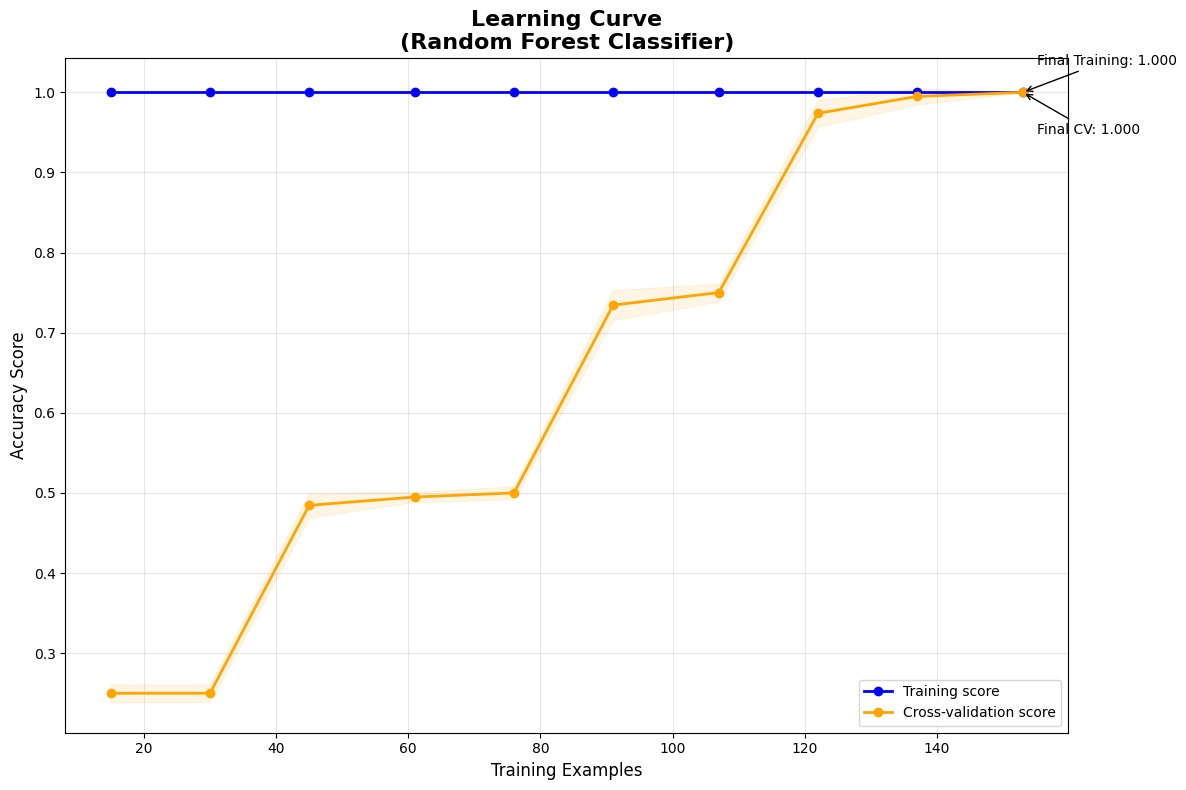


Learning Curve Analysis:
Final training score: 1.0000
Final cross-validation score: 1.0000
Generalization gap: 0.0000
 Good generalization performance


In [124]:
# Enhanced Learning Curve
train_sizes, train_scores, test_scores = learning_curve(
    RandomForestClassifier(n_estimators=100, random_state=42),
    X_scaled, y_encoded, cv=5, n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10),
    scoring='accuracy', random_state=42
)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize=(12, 8))
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color='blue')
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color='orange')
plt.plot(train_sizes, train_scores_mean, 'o-', color='blue', 
         label='Training score', linewidth=2, markersize=6)
plt.plot(train_sizes, test_scores_mean, 'o-', color='orange',
         label='Cross-validation score', linewidth=2, markersize=6)

plt.title('Learning Curve\n(Random Forest Classifier)', fontsize=16, fontweight='bold')
plt.xlabel('Training Examples', fontsize=12)
plt.ylabel('Accuracy Score', fontsize=12)
plt.legend(loc='best')
plt.grid(True, alpha=0.3)

# Add final performance annotations
final_train_score = train_scores_mean[-1]
final_test_score = test_scores_mean[-1]
gap = final_train_score - final_test_score

plt.annotate(f'Final Training: {final_train_score:.3f}',
             xy=(train_sizes[-1], final_train_score),
             xytext=(10, 20), textcoords='offset points',
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))

plt.annotate(f'Final CV: {final_test_score:.3f}',
             xy=(train_sizes[-1], final_test_score),
             xytext=(10, -30), textcoords='offset points',
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))

plt.tight_layout()
plt.show()

print(f"\nLearning Curve Analysis:")
print(f"Final training score: {final_train_score:.4f}")
print(f"Final cross-validation score: {final_test_score:.4f}")
print(f"Generalization gap: {gap:.4f}")
if gap > 0.1:
    print(" Large gap indicates potential overfitting")
else:
    print(" Good generalization performance")

# 8. Summary and Conclusions

Comprehensive summary of the facial recognition model performance and insights.

In [125]:
print("=" * 70)
print("FACIAL RECOGNITION MODEL - COMPREHENSIVE SUMMARY")
print("=" * 70)

print(f"\n DATASET OVERVIEW:")
print(f"   Dataset: {IMAGE_FEATURES_PATH.name}")
print(f"   Original shape: {df.shape}")
print(f"   Target variable: {target_col}")
print(f"   Number of classes: {len(np.unique(y_encoded))}")
print(f"   Features after preprocessing: {X_scaled.shape[1]}")

print(f"\n MODEL PERFORMANCE SUMMARY:")
print(f"   Accuracy: {accuracy:.4f}")
print(f"   F1-Score: {f1:.4f}")
print(f"   Log Loss: {log_loss:.4f}")
print(f"   Cross-Validation: {cv_scores.mean():.4f} ± {cv_scores.std() * 2:.4f}")

print(f"\n KEY INSIGHTS:")
print(f"   1. Model Performance: {'Excellent' if accuracy > 0.9 else 'Good' if accuracy > 0.8 else 'Moderate' if accuracy > 0.7 else 'Needs Improvement'}")
print(f"   2. Top 3 Features: {list(feature_importances['feature'].head(3))}")
print(f"   3. Dataset Balance: {'Balanced' if (df[target_col].value_counts().max() / df[target_col].value_counts().min()) < 2 else 'Imbalanced'}")
print(f"   4. Feature Quality: {len(feature_importances[feature_importances['importance'] > 0.01])} features with importance > 0.01")
print(f"   5. Generalization: {'Good' if (train_scores_mean[-1] - test_scores_mean[-1]) < 0.1 else 'Potential Overfitting'}")

if len(feature_importances[feature_importances['importance'] > 0.01]) < 10:
    print("   • Few strong features - consider feature selection")

print("\n" + "=" * 70)

FACIAL RECOGNITION MODEL - COMPREHENSIVE SUMMARY

 DATASET OVERVIEW:
   Dataset: image_features.csv
   Original shape: (192, 45)
   Target variable: member
   Number of classes: 4
   Features after preprocessing: 73

 MODEL PERFORMANCE SUMMARY:
   Accuracy: 1.0000
   F1-Score: 1.0000
   Log Loss: 0.0774
   Cross-Validation: 1.0000 ± 0.0000

 KEY INSIGHTS:
   1. Model Performance: Excellent
   2. Top 3 Features: ['width', 'height', 'edge_density']
   3. Dataset Balance: Balanced
   4. Feature Quality: 24 features with importance > 0.01
   5. Generalization: Good



# 9. Save Model and Results

Persist the trained model, preprocessing objects, and evaluation results for future use.

In [126]:
# Create results directory
results_dir = NOTEBOOK_DIR / "model_results"
results_dir.mkdir(exist_ok=True)

# Save model
joblib.dump(rf_model, results_dir / "facial_recognition_model.pkl")
joblib.dump(scaler, results_dir / "scaler.pkl")
if 'le' in locals():
    joblib.dump(le, results_dir / "label_encoder.pkl")

# Save feature importances
feature_importances.to_csv(results_dir / "feature_importances.csv", index=False)

# Save performance metrics
performance_metrics = {
    'accuracy': float(accuracy),
    'f1_score': float(f1),
    'log_loss': float(log_loss),
    'cv_mean': float(cv_scores.mean()),
    'cv_std': float(cv_scores.std())
}

with open(results_dir / "performance_metrics.json", 'w') as f:
    json.dump(performance_metrics, f, indent=4)

print("Model and results saved successfully!")
print(f"Saved to: {results_dir}")
print("\nFiles saved:")
print("- facial_recognition_model.pkl (trained model)")
print("- scaler.pkl (feature scaler)")
print("- label_encoder.pkl")
print("- feature_importances.csv")
print("- performance_metrics.json")

Model and results saved successfully!
Saved to: c:\Users\LENOVO\Desktop\Formative-2__Data-Preprocessing\model_notebook\model_results

Files saved:
- facial_recognition_model.pkl (trained model)
- scaler.pkl (feature scaler)
- label_encoder.pkl
- feature_importances.csv
- performance_metrics.json
